This notebook contains code from the following tutorials:

* https://towardsdatascience.com/best-practice-to-calculate-and-interpret-model-feature-importance-14f0e11ee660
* https://medium.com/@T_Jen/feature-importance-for-any-model-using-permutation-7997b7287aa
* https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.base import clone

In [2]:
df = pd.read_csv('data/train_titanic.csv')
df = df.dropna(subset=['Survived'])

X = df.drop("Survived", axis = 1)
y = df['Survived']

In [3]:
categorical_columns = ["Pclass", "Sex", "Embarked"]
numerical_columns = ["Age", "SibSp", "Parch", "Fare"]

In [4]:
#did a simple imputation to fill missing categorical var with mode. The only var missing is embarked with 2 missing values 
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])

enc = OrdinalEncoder()
X[categorical_columns] = enc.fit_transform(X[categorical_columns] )

#imputed numerical var missing values with mean 
X[numerical_columns] = X[numerical_columns].apply(lambda x: x.fillna(np.mean(x)))

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    random_state=42)

In [5]:
rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 1,
         oob_score=True,
         random_state = 42)
rf.fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.982
RF test accuracy: 0.767


In [6]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

In [7]:
print(f"RF train RMSE: {accuracy_score(y_train, y_pred_train):.3f}")
print(f"RF test RMSE: {accuracy_score(y_test, y_pred_test):.3f}")

RF train RMSE: 0.982
RF test RMSE: 0.767


## Random Forest Feature Importance

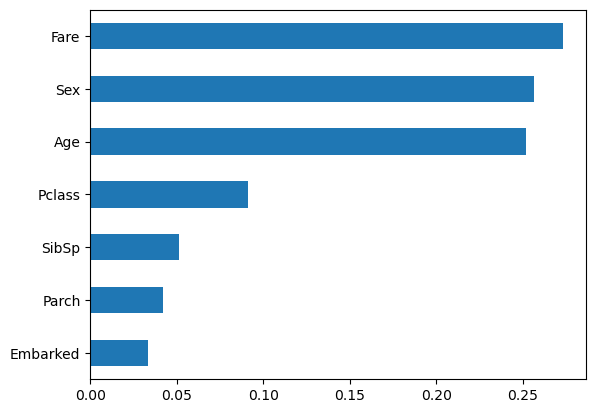

In [8]:
feat_importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

## Permutation importance

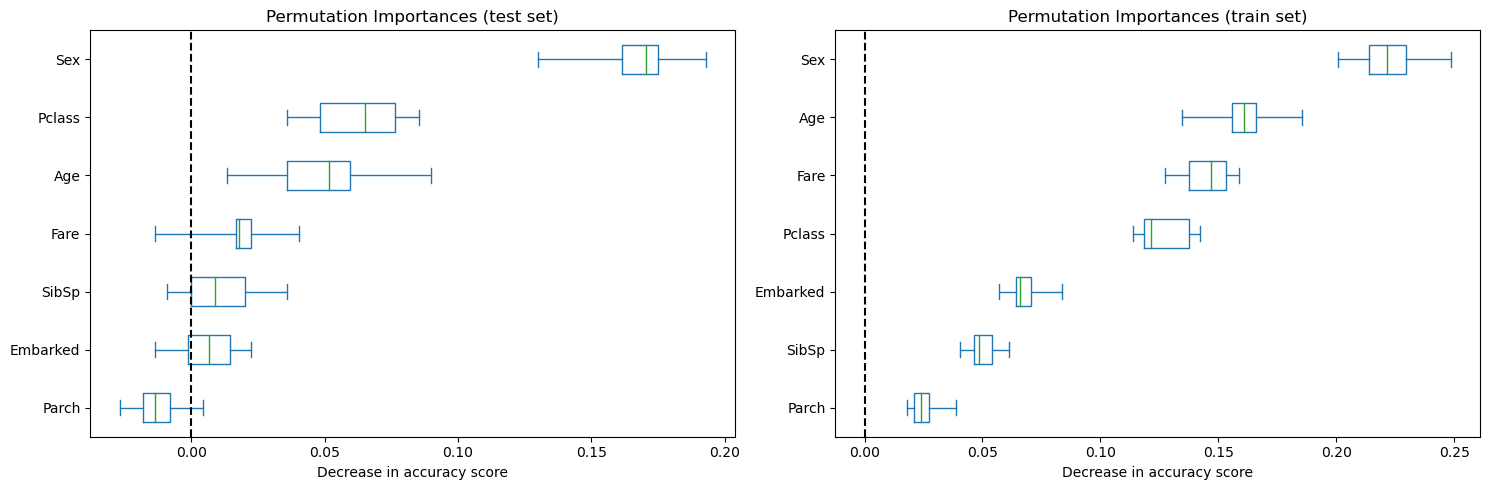

In [9]:
result_test = permutation_importance(
    rf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    rf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

## A robust model

In [10]:

rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 20,
         oob_score=True,
         random_state = 42)

rf.fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.826
RF test accuracy: 0.776


## Drop column importances

<AxesSubplot:ylabel='Feature'>

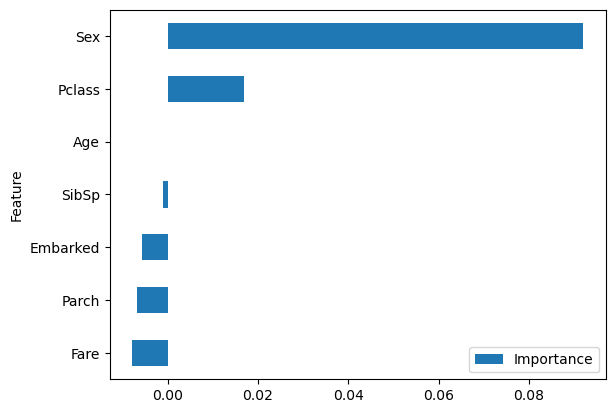

In [11]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 42
    rf_.fit(X_train, y_train)
    
    #use out of bag error as performance measurement
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 42
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I


imp = dropcol_importances(rf, X, y)
imp.plot(kind = 'barh')

## Collinearity

<AxesSubplot:>

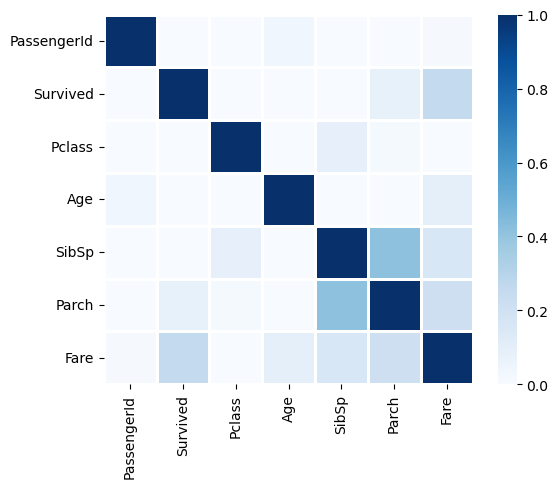

In [12]:
corr = df.corr()
sns.heatmap(corr, vmin=0, vmax=1, linewidths=2, square=True, cmap='Blues')

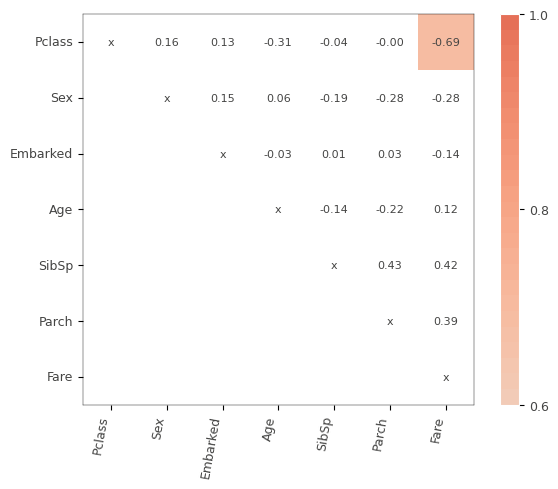

In [13]:
from rfpimp import plot_corr_heatmap
from rfpimp import *

viz = plot_corr_heatmap(X_train, figsize=(7,5))
viz.view()

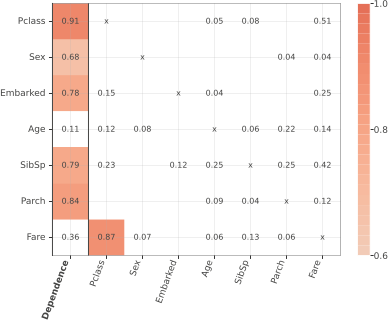

In [14]:
dependence_matrix = feature_dependence_matrix(X_train,
                          rfrmodel=RandomForestRegressor(n_estimators=50, oob_score=True),
                          rfcmodel=RandomForestClassifier(n_estimators=50, oob_score=True),
                          cat_count=20,
                          zero=0.001,
                          sort_by_dependence=False,
                          n_samples=5000)

plot_dependence_heatmap(dependence_matrix)

## eli5 package

In [15]:
import eli5
from eli5.sklearn import PermutationImportance

/Users/lilianabadillo/opt/anaconda3/envs/kaggle/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [16]:
perm = PermutationImportance(rf).fit(X_test, y_test)
eli5.show_weights(perm)

Weight,Feature
0.1937 ± 0.0280,x1
0.0242 ± 0.0209,x2
0.0170 ± 0.0132,x0
0.0081 ± 0.0036,x5
0.0063 ± 0.0209,x4
-0.0090 ± 0.0260,x3
-0.0099 ± 0.0174,x6


In [17]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 157 to 639
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    223 non-null    float64
 1   Sex       223 non-null    float64
 2   Embarked  223 non-null    float64
 3   Age       223 non-null    float64
 4   SibSp     223 non-null    int64  
 5   Parch     223 non-null    int64  
 6   Fare      223 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 13.9 KB


## Improving model

In [18]:
categorical_columns = ["Pclass", "Sex", "Embarked"]
numerical_columns = ["Age", "SibSp", "Parch", "Fare"]

In [19]:
X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    random_state=42)

In [20]:
rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 20,
         oob_score=True,
         random_state = 42)
rf.fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 0.826
RF test accuracy: 0.776


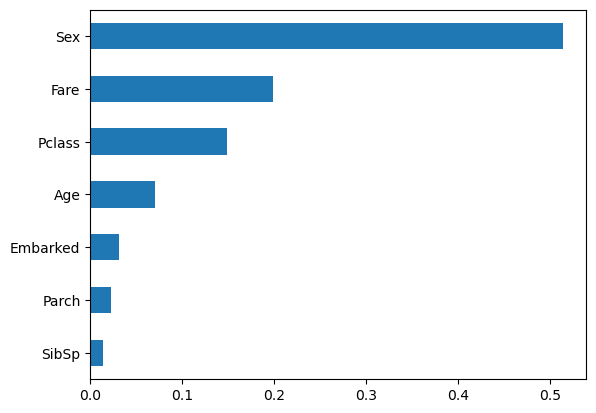

In [21]:
feat_importances = pd.Series(rf.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

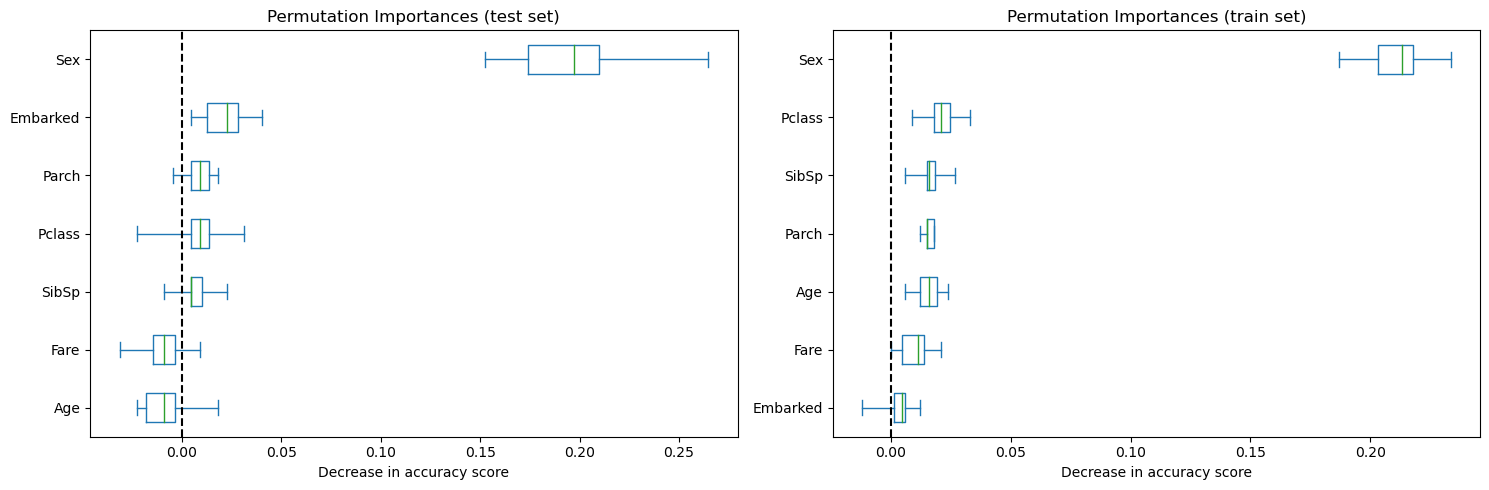

In [22]:
result_test = permutation_importance(
    rf, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    rf, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

<AxesSubplot:ylabel='Feature'>

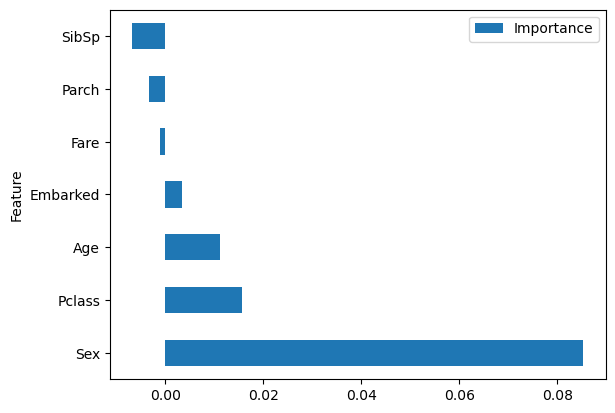

In [23]:
imp = dropcol_importances(rf, X, y)
imp.plot(kind = 'barh')